# Projet 6 – Introduction au MLOps : classification bancaire

Vous allez explorer les bases du MLOps en versionnant et suivant un modèle de classification binaire (octroi de crédit) grâce à des outils comme MLflow.

🔧 Objectifs :
- Suivi des performances d’un modèle
- Gestion des hyperparamètres
- Contrôle du surapprentissage

Data :
- Données issues [kaggle](https://www.kaggle.com/c/GiveMeSomeCredit/data)

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

FILE_INFO = "Data Dictionary"
FILE_TEST = "cs-test"
FILE_TRAINING = "cs-training"
FILE_SAMPLE_ENTRY = "sampleEntry"
DATA_INFO = pd.read_excel(f"../data/{FILE_INFO}.xls")
DATA_TEST = pd.read_csv(f"../data/{FILE_TEST}.csv", index_col=0)
DATA_TRAINING = pd.read_csv(f"../data/{FILE_TRAINING}.csv", index_col=0)
DATA = pd.concat([DATA_TRAINING, DATA_TEST], axis=0, ignore_index=True)
print(DATA.columns)
print(DATA.shape)
DATA.dropna(axis=0, how='any', inplace=True)
DATA.reset_index(drop=True, inplace=True)
DATA.head()

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')
(251503, 11)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1.0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0.0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0.0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0.0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0.0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


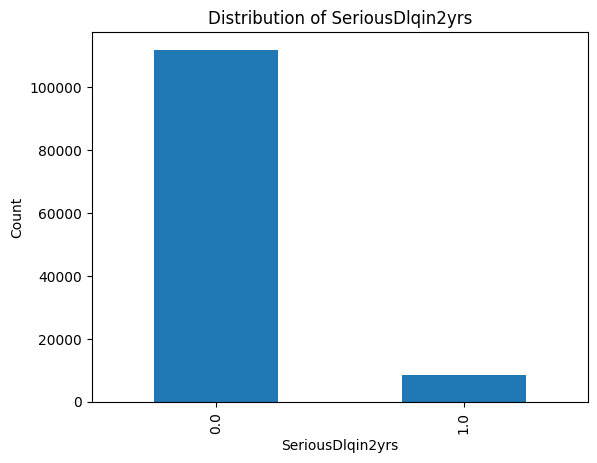

SeriousDlqin2yrs
0.0    8357
1.0    8357
Name: count, dtype: int64


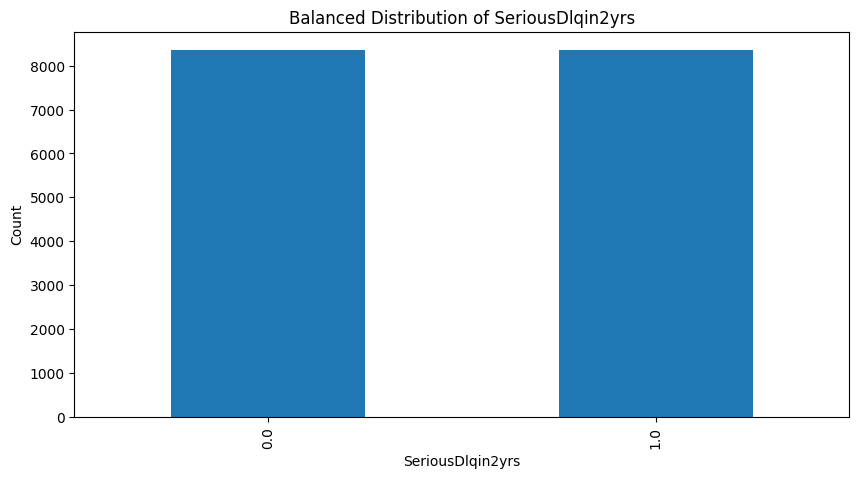

In [2]:
# équilibrage des classes
DATA['SeriousDlqin2yrs'].value_counts().plot(kind='bar')
plt.title('Distribution of SeriousDlqin2yrs')
plt.xlabel('SeriousDlqin2yrs')
plt.ylabel('Count')
plt.show()

# garder autant de 0 que de 1, il y a beaucoup plus de 0 que de 1
# on va donc réduire les 0 pour équilibrer
DATA_0 = DATA[DATA['SeriousDlqin2yrs'] == 0]
DATA_1 = DATA[DATA['SeriousDlqin2yrs'] == 1]
DATA_0_sample = DATA_0.sample(n=len(DATA_1), random_state=42)
DATA = pd.concat([DATA_0_sample, DATA_1], axis=0, ignore_index=True)
print(DATA['SeriousDlqin2yrs'].value_counts())
# réinitialiser les index
DATA.reset_index(drop=True, inplace=True)
plt.figure(figsize=(10, 5))
DATA['SeriousDlqin2yrs'].value_counts().plot(kind='bar')
plt.title('Balanced Distribution of SeriousDlqin2yrs')
plt.xlabel('SeriousDlqin2yrs')
plt.ylabel('Count')
plt.show()

Best Hyperparameters: {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}
Accuracy: 0.7550104696380496
Confusion Matrix:
 [[1377  294]
 [ 525 1147]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.82      0.77      1671
         1.0       0.80      0.69      0.74      1672

    accuracy                           0.76      3343
   macro avg       0.76      0.76      0.75      3343
weighted avg       0.76      0.76      0.75      3343



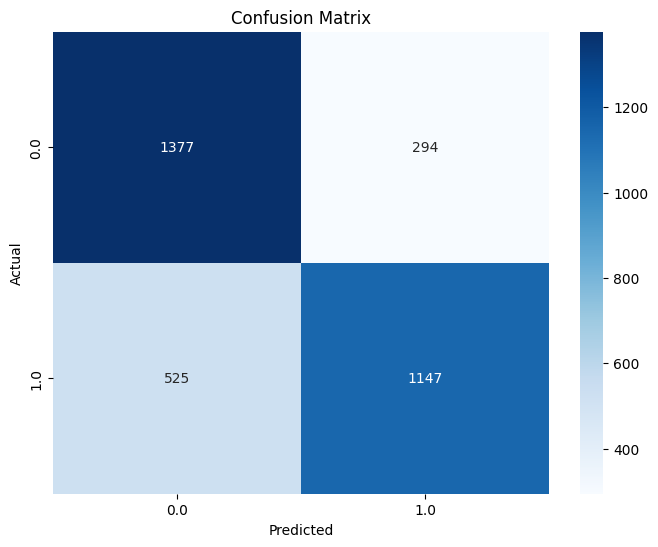

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X = DATA.drop(columns=['SeriousDlqin2yrs'])
y = DATA['SeriousDlqin2yrs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': [None, 'sqrt', 'log2'],
    'splitter': ['best', 'random'],
    'min_impurity_decrease': [0.0, 0.01, 0.1],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 2, 1: 1}],
    'ccp_alpha': [0.0, 0.01, 0.1]
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

model = DecisionTreeClassifier(**grid_search.best_params_)
model.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

model_rf = RandomForestClassifier(**grid_search_rf.best_params_)
model_rf.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search_rf.best_params_)

y_pred_rf = model_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Optimisation aussi d'un MLP

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class CrediScoringModelMLP(nn.Module):
    def __init__(self, input_size):
        super(CrediScoringModelMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x
    
def train_model(model, criterion, optimizer, train_loader, num_epochs=100, cuda=False):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            if cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

def evaluate_model(model, test_loader, cuda=False):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            if cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            outputs = model(inputs)
            preds = (outputs.squeeze() > 0.5).int()
            if cuda:
                preds = preds.cpu()
                labels = labels.cpu()
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    return np.array(all_preds), np.array(all_labels)

import torch.utils.data as data
class CrediScoringDataset(data.Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.int64)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = CrediScoringDataset(X_train, y_train)
test_dataset = CrediScoringDataset(X_test, y_test)
train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)

model_mlp = CrediScoringModelMLP(input_size=X_train.shape[1])
criterion = nn.BCELoss()

cuda = torch.cuda.is_available()
if cuda:
    model_mlp = model_mlp.cuda()
    criterion = criterion.cuda()

# optimisation des hyperparameters optimizer
parmas = {
    'lr': [0.001, 0.01, 0.1],
    'betas': [(0.9, 0.999), (0.95, 0.999)],
    'eps': [1e-08, 1e-07],
    'weight_decay': [0, 1e-05, 1e-04],
    'amsgrad': [True, False]
}
best_accuracy = 0
best_params = None
for lr in parmas['lr']:
    for betas in parmas['betas']:
        for eps in parmas['eps']:
            for weight_decay in parmas['weight_decay']:
                for amsgrad in parmas['amsgrad']:
                    optimizer = optim.Adam(model_mlp.parameters(), lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, amsgrad=amsgrad)
                    print(f'Training with lr={lr}, betas={betas}, eps={eps}, weight_decay={weight_decay}, amsgrad={amsgrad}')
                    train_model(model_mlp, criterion, optimizer, train_loader, num_epochs=20, cuda=cuda)
                    y_pred_mlp, y_test_mlp = evaluate_model(model_mlp, test_loader, cuda=cuda)
                    accuracy = accuracy_score(y_test_mlp, y_pred_mlp)
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_params = (lr, betas, eps, weight_decay, amsgrad)
                        
print("Best Hyperparameters for Optimizer:", best_params)

model_mlp = CrediScoringModelMLP(input_size=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=best_params[0], betas=best_params[1], eps=best_params[2], weight_decay=best_params[3], amsgrad=best_params[4])
if cuda:
    model_mlp = model_mlp.cuda()
    criterion = criterion.cuda()

train_model(model_mlp, criterion, optimizer, train_loader, num_epochs=20, cuda=cuda)
y_pred_mlp, y_test_mlp = evaluate_model(model_mlp, test_loader, cuda=cuda)

print("MLP Model Accuracy:", accuracy_score(y_test_mlp, y_pred_mlp))
print("MLP Confusion Matrix:\n", confusion_matrix(y_test_mlp, y_pred_mlp))
print("MLP Classification Report:\n", classification_report(y_test_mlp, y_pred_mlp))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_mlp, y_pred_mlp), annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test_mlp), yticklabels=np.unique(y_test_mlp))
plt.title('MLP Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Training with lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True
Epoch [1/20], Loss: 55.5556
Epoch [2/20], Loss: 29.6326
Epoch [3/20], Loss: 66.6667
Epoch [4/20], Loss: 25.9259
Epoch [5/20], Loss: 59.2593
Epoch [6/20], Loss: 55.5556
Epoch [7/20], Loss: 44.4444
Epoch [8/20], Loss: 44.4444
Epoch [9/20], Loss: 50.0393
Epoch [10/20], Loss: 42.4992
Epoch [11/20], Loss: 48.1740
Epoch [12/20], Loss: 66.6667
Epoch [13/20], Loss: 70.3704
Epoch [14/20], Loss: 40.7407
Epoch [15/20], Loss: 44.4696
Epoch [16/20], Loss: 34.1791
Epoch [17/20], Loss: 44.5213
Epoch [18/20], Loss: 55.5556
Epoch [19/20], Loss: 51.8519
Epoch [20/20], Loss: 48.1808
Training with lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False
Epoch [1/20], Loss: 44.4444
Epoch [2/20], Loss: 51.8519
Epoch [3/20], Loss: 26.4186
Epoch [4/20], Loss: 37.0370
Epoch [5/20], Loss: 40.7934
Epoch [6/20], Loss: 59.2593
Epoch [7/20], Loss: 51.8519
Epoch [8/20], Loss: 51.8519
Epoch [9/20], Loss: 51.8817
Epoch [1

KeyboardInterrupt: 